# Classifying Song Genres

__Author:__ Colin Cambo

__Date:__ 1/23/2017

__About:__ This notebook will see if it's possible to classify songs into their respective genre based solely upon their lyrics. To get the data I scrape Billboard for song information, and utilize the PyLyrics API to acquire the lyrics.

__Contents:__

  * [0 Introduction](#0)
    * [0.1 Requirements](#0.1)
  * [1 Getting Data](#1)
    * [1.1 Billboard](#1.1)
    * [1.2 PyLyrics](#1.2)
  * [2 Data Exploration](#2)
    * [2.1 Missing Data](#2.1)
    * [2.2 Word Cloud](#2.2)
  * [3 Modeling Data](#3)
    * [3.1 Vectorizing Lyrics](#3.1)
    * [3.2 Multinomial Naive Bayes](#3.2)
    * [3.3 Tuning Parameters](#3.3)
    * [3.4 Examining Model](#3.4)
    * [3.5 Stemming Lyrics](#3.5)
      * [3.5.1 Lancaster Stemming](#3.4.1)
      * [3.5.2 Porter Stemming](#3.4.2)
  * [4 Acquiring More Data](#4)
    * [4.1 Billboard](#4.1)
    * [4.2 PyLyrics](#4.2)
    * [4.3 New Data Analysis](#4.3)
      * [4.3.1 Zipf's Law](#4.3.1)
      * [4.3.2 Improved Word Cloud](#4.3.2)
    * [4.4 Stemming](#4.4)
  * [5 Modeling](#5)
    * [5.1 Benchmark Model](#5.1)
    * [5.2 TF-IDF with Multinomial Naive Bayes](#5.2)
    * [5.3 Feature Extraction](#5.3)
      * [5.3.1 Token Count](#5.3.1)
      * [5.3.2 Percent Unique Words](#5.3.2)
    * [5.4 Model Optimization](#5.4)
      * [5.4.1 Creating Custom Transformers](#5.4.1)
      * [5.4.2 Finding parameters with RandomizedSeachCV](#5.4.2)
      * [5.4.3 Verifying Parameters](#5.4.3)
  * [6 Conclusion](#6)

<a id = '0'></a>
# 0 Introduction

When listening to a song a lot of people will be able to classify the song's genre. They probably would do this listening to the tempo, the instruments, and listening to the lyrics. What if someone only had the lyrics to a song though. Would they be able to classify that song?

This notebook attempts to classify the most popular songs over the past 6 years into their respective genre, based solely on lyrics.

<a id = '0.1'></a>
## 0.1 Requirements

For this notebook you must pip install the following packages:

  * PyLyrics
  * bs4
  * pandas
  * sklearn
  * wordcloud
  * nltk
  

<a id = '1'></a>
# 1 Getting the Data

Scraping the top songs and then classifying their genre proved to be difficult, so I opted to instead just use four different Billboard URL's that are already seperated by genre.

In [ ]:
import requests
from bs4 import BeautifulSoup
from PyLyrics import *
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

<a id = '1.1'></a>
## 1.1 Billboard

To get the top songs we will be using Billboard, which is a music website that keeps track of the top songs in many different Genres.

Below is a dictionary for each the genres we're interested in, and their corresponding URL's on the Billboard website.

In [2]:
url_dict = {
            'country':'http://www.billboard.com/charts/country-songs',
            'pop':'http://www.billboard.com/charts/pop-songs',
            'rock':'http://www.billboard.com/charts/hot-mainstream-rock-tracks',
            'hip-hop':'http://www.billboard.com/charts/r-b-hip-hop-songs'
    }

Below we're using BeautifulSoup to parse each URL for the songs and artists, and we're then saving this information into a list of tuples.

In [3]:
song_tuples = []
for key, value in url_dict.items():
    
    response = requests.get(value)
    soup = BeautifulSoup(response.text,"lxml")
    
    for div in soup.find_all('div',{'class':'chart-row__title'}):
    
        try:
            artist = div.find('a',{'class':'chart-row__artist'}).text.strip().split('Featuring')[0]
        except AttributeError:
            try:
                artist = div.find('h3',{'class':'chart-row__artist'}).text.strip().split('Featuring')[0]
            except:
                artist = "UNKNOWN"
        song = div.find('h2',{'class':'chart-row__song'}).text
        song_tuples.append((artist, song, key))

Here is what the first 10 tuples in our new list look like.

In [4]:
song_tuples[:10]

[('Keith Urban', "Blue Ain't Your Color", 'country'),
 ('Little Big Town', 'Better Man', 'country'),
 ('Carrie Underwood', 'Dirty Laundry', 'country'),
 ('Florida Georgia Line ', 'May We All', 'country'),
 ('Blake Shelton', 'A Guy With A Girl', 'country'),
 ('Thomas Rhett', 'Star Of The Show', 'country'),
 ('Brett Eldredge', 'Wanna Be That Song', 'country'),
 ('Jon Pardi', 'Dirt On My Boots', 'country'),
 ('Chris Stapleton', 'Tennessee Whiskey', 'country'),
 ('Dustin Lynch', "Seein' Red", 'country')]

<a id = '1.2'></a>
## 1.2 PyLyrics

The easiest way to get the lyrics for each song is to use the API PyLyrics, which just queries another API at lyrics.wikia.com

Below we're cycling through the tuples and calling PyLyrics's "getLyrics" function to get the lyrics for most of the songs.

Any songs we failed to get lyrics for will have "FAILED" as the Lyrics text so that it's easy to filter out rows without Lyrics.

In [5]:
from PyLyrics import *
lyrics = []
for artist, song, _ in song_tuples:
    try:
        lyrics.append(PyLyrics.getLyrics(artist, song))
    except ValueError:
        lyrics.append('FAILED')

For the sake of familiarity we will turn this tuple into a pandas DataFrame object, and append the column 'Lyrics' to it.

In [8]:
df = pd.DataFrame(song_tuples, columns=['Artist', 'Song', 'Genre'])
df['Lyrics'] = lyrics

<a id = '2'></a>
# 2 Data Exploration

Now that we have a DataFrame of all our data we can explore it quite easily.

In [11]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline

df.head(10)

,Artist,Song,Genre,Lyrics
0,Keith Urban,Blue Ain't Your Color,country,I can see you over there\nStaring at your drin...
1,Little Big Town,Better Man,country,I know I’m probably better off on my own\nThan...
2,Carrie Underwood,Dirty Laundry,country,"That lipstick on your collar, \nWell it ain't ..."
3,Florida Georgia Line,May We All,country,May we all get to grow up in our red white and...
4,Blake Shelton,A Guy With A Girl,country,Sometimes I'm the guy with the boys kicking it...
5,Thomas Rhett,Star Of The Show,country,Walking down the street hand in mine\nIt don't...
6,Brett Eldredge,Wanna Be That Song,country,The radio and a sundress\nMaking my world all ...
7,Jon Pardi,Dirt On My Boots,country,Been up since the crack of dawn\nJust trying t...
8,Chris Stapleton,Tennessee Whiskey,country,Used to spend my nights out in bar rooms\nLiqu...
9,Dustin Lynch,Seein' Red,country,FAILED


Examining the distribution of our Genre shows us that the data is about equally split.

In [13]:
Counter(df['Genre'])

Counter({'country': 50, 'hip-hop': 50, 'pop': 40, 'rock': 40})

<a id = '2.1'></a>
## 2.1 Missing Data

Our data set might now be equally split though, because as we can see some the head of the DataFrame above, some rows don't have Lyrics. Below we're checking how many rows don't have lyrics.

In [14]:
sum(df['Lyrics'] == 'FAILED')

48

Dropping the rows without lyrics leaves us with the following distribution:

In [15]:
df2 = df[df['Lyrics'] != 'FAILED']

Counter(df2['Genre'])

Counter({'country': 34, 'hip-hop': 35, 'pop': 36, 'rock': 27})

From this distribution we see that Rock songs have significantly less entries than other genres, but we will try to model the data regardless.

<a id = '2.2'></a>
## 2.2 Word Cloud

Before modeling the data we will create a word cloud to see if we can find any significant patterns before modeling begins, also it's interesting to see the stark contrast the genres have in terms of word usage.

Rather than printing out four different word cloud we're going to utilize the @interact decorator inside ipywidgets to make a drop down box for every genre. If you want to see a word cloud for a different genre you now just have to select the genre in the drop down box.

__Note:__ The lyrics are unedited so some vulgarities will show up in the word clouds.

In [ ]:
from ipywidgets import interact
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

genre_list = ['country', 'hip-hop', 'pop', 'rock']

@interact
def plot_word_cloud(genre=genre_list):
    
    sample_df = df2[df2['Genre'] == genre]
    text = ' '.join(sample_df['Lyrics'].tolist())
    wordcloud = WordCloud(max_font_size=60, stopwords=ENGLISH_STOP_WORDS).generate(text)
        
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('WordCloud for {}'.format(genre))

<a id = '3'></a>
# 3 Modeling Data

Now that we removed missing data, we're ready to begin the modeling process.

In [17]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [18]:
X = df2['Lyrics'] #Column for Document-Term-Matrix
y = df2['Genre'] #Target (What we're trying to predict)

<a id = '3.1'></a>
## 3.1 Vectorizing Lyrics

When creating a model for text data you first have to turn the text into a numeric representation. Lucky for us sklearn's CountVectorizer does exactly that.

One argument that the CountVectorizer takes is a stop_words list. Below we're looking at the shape of our resulting Document-Term-Matrix with and without stop words being used.

In [20]:
for stop_words in [None, "english"]:

    vect = CountVectorizer(ngram_range=(1,1), stop_words=stop_words)
    df2_dtm = vect.fit_transform(X)
    print('The shape of our dtm with stop_words={} is: {}'.format(stop_words, df2_dtm.shape))

The shape of our dtm with stop_words=None is: (132, 3496)
The shape of our dtm with stop_words=english is: (132, 3267)


As we can see from the output above our matrix is very wide because each word is mapped to it's own column, and the stop words really don't remove that many words in our matrix. Later on we'll try some other techniques like stemming to reduce the number of features, but for now we won't worry about it, because the model we're going to use works nicely with high dimensional data.

<a id = '3.2'></a>
## 3.2 Multinomial Naive Bayes

Due to the high dimension of our dataset we're going to use Multinomial Naive Bayes to model our data. Multinomial Naive Bayes is known for its very quick speed and its knack for dealing with high dimensional data, so this is our model of choice.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

We don't necessarily know the best parameters for the model, but we can guess which ones will be the most optimal, and try those out.

For this first model we are going to try using both uni-grams and bi-grams, and English stop words.

In [38]:
vect = CountVectorizer(ngram_range=(1,2), stop_words=ENGLISH_STOP_WORDS)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

clf = MultinomialNB()

clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

    country       0.67      0.80      0.73        10
    hip-hop       0.82      0.82      0.82        11
        pop       0.50      0.44      0.47         9
       rock       1.00      0.67      0.80         3

avg / total       0.70      0.70      0.69        33



As we can see this gave us a bad model for predicting genres. Luckily there are many steps we can take to improve our model.

<a id = '3.3'></a>
## 3.3 Tuning Parameters

One of the best ways is to stop guessing with parameters and find the optimal ones. We are going to use GridSearchCV from sklearn to find optimal parameters for our classifier

In [30]:
X = df2['Lyrics']
y = df2['Genre']

Here I am creating a split to test on after GridSearchCV finds the optimal parameters. This is needed because every piece of other data has been used to find the parameters except for the test sample declared here.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)

Once again we will be using Multinomial Naive Bayes for modeling because of its speed and accuracy for text classification

In [32]:
pipe = make_pipeline(CountVectorizer(stop_words='english'), MultinomialNB())

#These are the parameters we're searching over
params = {
    'countvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
    'countvectorizer__min_df':[0, 2, 3, 4, 5, 6, 7, 8]
}

grid = GridSearchCV(pipe, params, cv=5)
grid.fit(X_train, y_train)
print("Best CV Score: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Score for test sample held out: {}".format(accuracy_score(y_test, grid.predict(X_test))))

Best CV Score: 0.64
Best parameters: {'countvectorizer__ngram_range': (1, 1), 'countvectorizer__min_df': 2}
Score for test sample held out: 0.7142857142857143


<a id = '3.4'></a>
## 3.4 Examining Model
Not horrible for such a small dataset. Lets see what the defining words were for each genre. 

Lucky for us there is a way to extract the CountVectorizer and the MultinomialNB classifier from our grid object. 

Below we created a function that takes in a GridSearchCV object that's been fitted, selects the best estimator from the GridSearchCV object, and then outputs a DataFrame that will contain the ratios of how often each word was used in a genre, compared to all the others.

In [84]:
def get_ratio_df(grid): 
    
    grid_clf = grid.best_estimator_.named_steps['multinomialnb'] 
    count_vect = grid.best_estimator_.named_steps['countvectorizer']
    names = count_vect.get_feature_names()
    
    country = (grid_clf.feature_count_[0] + 1)/grid_clf.class_count_[0]
    hip_hop = (grid_clf.feature_count_[1] + 1)/grid_clf.class_count_[1]
    pop = (grid_clf.feature_count_[2] + 1)/grid_clf.class_count_[2]
    rock = (grid_clf.feature_count_[3] + 1)/grid_clf.class_count_[3]
    
    country_ratio = country/(hip_hop+pop+rock)
    hip_hop_ratio = hip_hop/(country+pop+rock)
    pop_ratio = pop/(hip_hop+country+rock)
    rock_ratio = rock/(hip_hop+pop+country)
    
    ratio_df = pd.DataFrame({'Token':names, 'country':country_ratio, 'hip-hop':hip_hop_ratio,
                             'pop':pop_ratio, 'rock':rock_ratio})
    return ratio_df

 We create another function below that will take in the DataFrame returned from the function above and print out the 10 highest valued word for each genre. 

In [81]:
def get_most_important(ratio_df, num):
    
    for column in ratio_df.columns[1:]:
        print("Most Frequent words for {}:\n".format(column), ratio_df.sort_values(by=column,
                                                                                ascending=False)[['Token', column]][:num])

In [85]:
f = get_ratio_df(grid)
f.head()

,Token,country,hip-hop,pop,rock
0,10,0.155354,1.352668,0.149772,0.190934
1,100,0.062667,3.106098,0.128996,0.075630
2,20,0.107030,0.704738,0.599088,0.130295
3,21,0.063063,2.306264,0.208319,0.076113
4,24,0.032479,1.017752,0.744097,0.038968


Printing out the 10 most frequent words for each genre can provide insight into our model building process, and can help us to confirm that our data is being tokenized correctly.

In [86]:
get_most_important(f, 10)

Most Frequent words for country:
         Token    country
818      road  10.835835
1115     whoa  10.526240
103      boot   7.739882
1113  whiskey   3.405548
656     momma   3.405548
210   countri   3.256580
299       dry   3.095953
235     daddi   2.791354
680      neon   2.786358
1120   window   2.558741
Most Frequent words for hip-hop:
        Token    hip-hop
683    nigga  18.062829
84     bitch  17.618449
46       aye  14.879350
407      gon  10.483019
1127    woke   9.505209
282     dope   7.777842
110    bounc   6.471037
841   savage   5.748840
39       ass   5.435671
711    paper   5.410673
Most Frequent words for pop:
        Token        pop
609      low  10.653601
954  stamina   4.698067
642  million   4.180160
672      nah   4.121635
919  slumber   3.915389
174     clap   3.355762
17       age   2.955396
65       bed   2.673419
558     lead   2.673419
798   reason   2.521184
Most Frequent words for rock:
        Token      rock
143     care  8.926207
894     sick  8.129342

This list matches up with what we'd expect to see for each genre.

<a id = '3.5'></a>
## 3.5 Stemming Lyrics

One way to achieve better results is to stem the words, because this will drastically reduce our feature space because words like "dancing" and "dances" will be truncated into the column "danc".

There are many different stemmers out there and we could even create our own stemmer with regular expressions, but for this notebook we will be trying NLTK's LancasterStemmer and PorterStemmer and seeing which one performs better.

Lancaster is known as a more aggressive stemmer, so it will be interesting to see how the two stack up.

In [129]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

lancast_stemmer = LancasterStemmer()
porter_stemmer = PorterStemmer()

Below we are applying both stemmers to our Lyrics and setting the results equal to a new column each. This is so we don't have to stem our Lyrics before every model we try. So the little extra memory this takes up is well worth the boost the speed.

It is worth noting as well that we aren't stemming the stop words because we want to be able to filter them out easily later on.

In [47]:
df2['Lyrics_Lancast_Stem'] = df2['Lyrics'].apply(lambda x: ' '.join([lancast_stemmer.stem(y) if y not in ENGLISH_STOP_WORDS 
                                                                     else y for y in x.split()]))
df2['Lyrics_Porter_Stem'] = df2['Lyrics'].apply(lambda x: ' '.join([porter_stemmer.stem(y) if y not in ENGLISH_STOP_WORDS 
                                                                    else y for y in x.split()]))

Below is a simple comparison between the stemmers for one of the songs. If you look at the first sentence you can see the word "probably" was stemmed to "prob" by the LancasterStemmer and "probabli" by the PorterStemmer. This follows exactly what we'd expect because the LancasterStemmer is known for being a more aggressive stemmer.

In [48]:
print('Lancaster Stemming: {}\nPorter Stemming: {}'.format(df2.ix[1, 'Lyrics_Lancast_Stem'], df2.ix[1, 'Lyrics_Porter_Stem']))

Lancaster Stemming: i know i’m prob bet off on my own than lovin' a man who didn’t know what he had when he had it and i see the perm dam you did to me nev again, i just wish i could forget when it was mag i wish it wasn’t 4 am, stand in the mir say to myself, you know you had to do it i know the bravest thing i ev did was run sometimes, in the middl of the night, i can feel you again but i just miss you, and i just wish you wer a bet man and i know why we had to say goodby lik the back of my hand and i just miss you, and i just wish you wer a bet man a bet man i know i’m prob bet off al alon than nee a man who could chang his mind at any giv minut and it’s alway on yo term i’m hang on every careless word hop it might turn sweet again lik it was in the begin but yo jealousy, i can hear it now you’re talk down to me lik i’ll alway be around you push my lov away lik it’s som kind of load gun boy, you nev thought i’d run sometimes, in the middl of the night, i can feel you again but i jus

In [53]:
lancast_vect = CountVectorizer(ngram_range=(1,1), stop_words=ENGLISH_STOP_WORDS)
porter_vect = CountVectorizer(ngram_range=(1,1), stop_words=ENGLISH_STOP_WORDS)

df2_dtm_lancast = lancast_vect.fit_transform(df2['Lyrics_Lancast_Stem'])
df2_dtm_porter = porter_vect.fit_transform(df2['Lyrics_Porter_Stem'])

print('The shape of our dtm after lancaster stemming is: {}'.format(df2_dtm_lancast.shape))
print('The shape of our dtm after porter stemming is: {}'.format(df2_dtm_porter.shape))

The shape of our dtm after lancaster stemming is: (132, 3349)
The shape of our dtm after porter stemming is: (132, 3318)


The dimensions of our document term matrix decreased. This means the stemmer worked

<a id = '3.5.1'></a>
### 3.5.1 Lancaster Stemming

In [56]:
X = df2['Lyrics_Lancast_Stem']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)

pipe = make_pipeline(CountVectorizer(stop_words=ENGLISH_STOP_WORDS), MultinomialNB())

params = {
    'countvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
    'countvectorizer__min_df':[0, 2, 3, 4, 5, 6, 7, 8]
}

grid = GridSearchCV(pipe, params, cv=5)
grid.fit(X_train, y_train)
print("Best CV Score: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Score for test sample held out: {}".format(accuracy_score(y_test, grid.predict(X_test))))

Best CV Score: 0.64
Best parameters: {'countvectorizer__ngram_range': (1, 1), 'countvectorizer__min_df': 2}
Score for test sample held out: 0.6428571428571429


<a id = '3.5.2'></a>
### 3.5.2 Porter Stemming

In [57]:
X = df2['Lyrics_Porter_Stem']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)

pipe = make_pipeline(CountVectorizer(stop_words=ENGLISH_STOP_WORDS), MultinomialNB())

params = {
    'countvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
    'countvectorizer__min_df':[0, 2, 3, 4, 5, 6, 7, 8]
}

grid = GridSearchCV(pipe, params, cv=5)
grid.fit(X_train, y_train)
print("Best CV Score: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Score for test sample held out: {}".format(accuracy_score(y_test, grid.predict(X_test))))

Best CV Score: 0.64
Best parameters: {'countvectorizer__ngram_range': (1, 1), 'countvectorizer__min_df': 2}
Score for test sample held out: 0.7142857142857143


These results from stemming the lyrics are not what we would expect to see for results. One potential reason that this is might be because the affixes are actually valuable when comparing genres because one genre might have lyrics that talk in the past tense more than another.

<a id = '4'></a>
# 4 Acquiring More Data

More data in our case is better than a better model, so we will go back to billboard and start scraping their historical data for 5 years.

__NOTE:__ Because this section takes so long I saved a DataFrame with the data that this section scrapes for. Uncomment the line below, run it, and then click [this](#read_csv) link to skip to the next section.

In [87]:
#final_df = pd.read_csv('song_data.csv')

<a id = '4.1'></a>
## 4.1 Billboard

The list comes out every saturday so the links will be different each year because the day of the week changes yearly.
Rather than making an algorithm to calculate for this, I just copied 5 of the past links, and put them into a dictionary below.

In [59]:
historical_link_dict = {
    2016:'/2016-01-02',
    2015:'/2015-01-03',
    2014:'/2014-01-04',
    2013:'/2013-01-05',
    2012:'/2012-01-07'
}

We are now copying the process of what we did in the first part, but we're adding another loop that will repeat the process for every year in the historical_link_dict.

In [66]:
hist_song_tuples = []
for key, value in url_dict.items():
    
    for year, year_url in historical_link_dict.items():
        response = requests.get(value + year_url)
        soup = BeautifulSoup(response.text,"lxml")

        for div in soup.find_all('div',{'class':'chart-row__title'}):

            try:
                artist = div.find('a',{'class':'chart-row__artist'}).text.strip().split('Featuring')[0]
            except AttributeError:
                try:
                    artist = div.find('h3',{'class':'chart-row__artist'}).text.strip().split('Featuring')[0]
                except:
                    artist = "UNKNOWN"
            song = div.find('h2',{'class':'chart-row__song'}).text
            hist_song_tuples.append((artist, song, key, year))

In [68]:
hist_song_tuples[:10]

[('Thomas Rhett', 'Die A Happy Man', 'country', 2016),
 ('Cam', 'Burning House', 'country', 2016),
 ('Sam Hunt', 'Break Up In A Small Town', 'country', 2016),
 ('Emily Ann Roberts', 'Burning House', 'country', 2016),
 ('Brothers Osborne', 'Stay A Little Longer', 'country', 2016),
 ('Chris Young', "I'm Comin' Over", 'country', 2016),
 ('Luke Bryan ', 'Home Alone Tonight', 'country', 2016),
 ('Blake Shelton', 'Gonna', 'country', 2016),
 ('Jason Aldean', 'Gonna Know We Were Here', 'country', 2016),
 ('Cole Swindell', 'You Should Be Here', 'country', 2016)]

In [69]:
len(hist_song_tuples)

900

<a id = '4.2'></a>
## 4.2 PyLyrics

Now that we got 900 more rows of song data, we're going to have to query the PyLyric's API 900 more times. I don't know if there is a limit on the API calls for lyrics, but we are going to try anyways.

In [70]:
hist_lyrics = []
for artist, song, genre, year in hist_song_tuples:
    try:
        hist_lyrics.append(PyLyrics.getLyrics(artist, song))
    except ValueError:
        hist_lyrics.append('FAILED')

Here we are combining the data set from early with the new dataset that we just acquired.

In [71]:
total_artists = [artist[0] for artist in hist_song_tuples] + [artist[0] for artist in song_tuples]
total_songs = [song[1] for song in hist_song_tuples] + [song[1] for song in song_tuples]
total_genres = [genre[2] for genre in hist_song_tuples] + [genre[2] for genre in song_tuples]
total_lyrics = [lyric for lyric in hist_lyrics] + [lyric for lyric in lyrics]
total_years = [year[3] for year in hist_song_tuples] + [2017 for year in song_tuples]

In [72]:
print('Length artists: {}\nsongs: {}\ngenres: {}\nlyrics: {}\nyears: {}'.format(len(total_artists), len(total_songs),
                                                                                len(total_genres), len(total_lyrics),
                                                                                len(total_years)))

Length artists: 1080
songs: 1080
genres: 1080
lyrics: 1080
years: 1080


This is the new length of our dataset and due to familiarity again we are once again going to convert this data into a pandas DataFrame.

In [73]:
final_df = pd.DataFrame({'Artist':total_artists, 'Song':total_songs, 'Genre':total_genres,
                         'Lyrics':total_lyrics, 'Years':total_years})

<a id = '4.3'></a>
## 4.3 New Data Analysis

Now that we have a new data set we need to analyze what's in it again. 

One of the first things we're going to do is remove all the rows that don't have lyrics.

In [74]:
sum(final_df['Lyrics'] == 'FAILED')

122

In [75]:
final_df = final_df[final_df['Lyrics'] != 'FAILED']

In [76]:
Counter(final_df['Genre'])

Counter({'country': 267, 'hip-hop': 253, 'pop': 226, 'rock': 212})

<a id="4.3.1"></a>
### 4.3.1 Zipf's Law

We know that text data will follow Zipf's law, but we don't know if that's true from song lyrics.

Lets look at what our frequency looks like for our data.

In [286]:
from functools import reduce

#Here we're just combining all our lyrics into one massive string
all_lyrics = reduce((lambda x, y: x + y), map(lambda x: x.split(), final_df['Lyrics'].tolist()))

Below we're just utilizing Counter to count the occurrence of every word

In [299]:
count = Counter(all_lyrics)

In [300]:
#Sorting counts
word_counts = sorted(list(count.items()), key=lambda x:x[1], reverse=True)

In [301]:
#Displaying first 10
word_counts[:10]

[('I', 13228),
 ('the', 11641),
 ('you', 10507),
 ('a', 6673),
 ('to', 6574),
 ('it', 5135),
 ('me', 5123),
 ('my', 4828),
 ("I'm", 4214),
 ('and', 4102)]

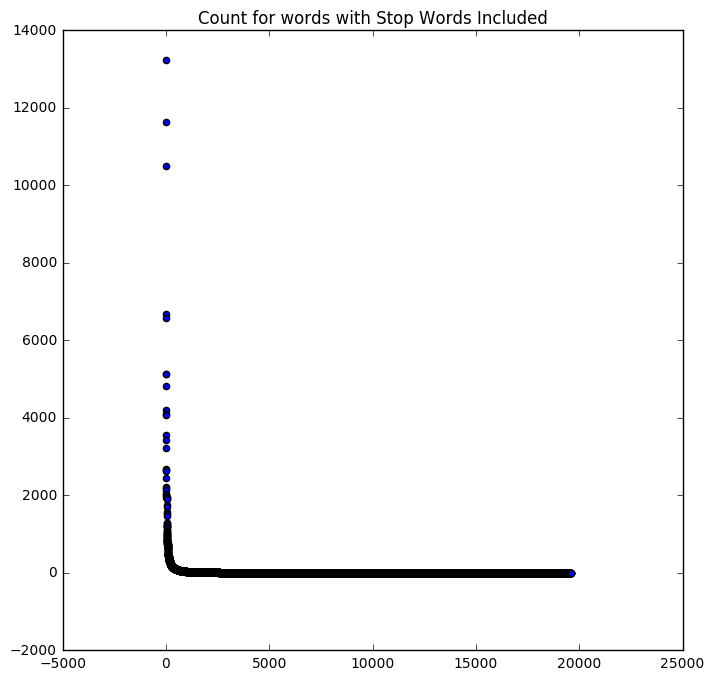

In [303]:
plt.figure(figsize=(8,8))
plt.scatter(x=range(len(word_counts)), y=[w[1] for w in word_counts])
plt.title('Count for Words')
plt.ylabel('Count')
plt.xlabel('Word')

As we can see from the chart above the words definitely follow Zipf's distribution.

<a id = 'read_csv'></a>
<a id = '4.3.2'></a>
### 4.3.2  Improved Word Cloud

Now that we have more data our word cloud will be a more accurate representation of the genre. We also can add a new parameter below that will create a word cloud for any specific year. This could be used to see how language evolves over time.

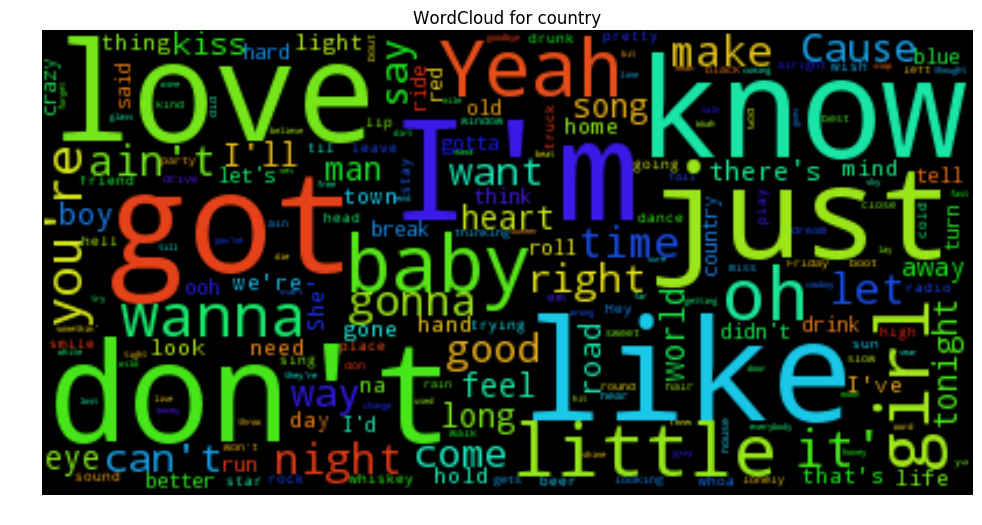

In [88]:
unstemmed_df = final_df.copy()
year_list = ['All', 2012, 2013, 2014, 2015, 2016, 2017]

@interact
def plot_word_cloud(genre=genre_list, year=year_list):
    
    if year == "All":
        sample_df = unstemmed_df[unstemmed_df['Genre'] == genre]
    else:
        sample_df = final_df[(unstemmed_df['Genre'] == genre) & (unstemmed_df['Years'] == int(year))]
    text = ' '.join(sample_df['Lyrics'].tolist())
    wordcloud = WordCloud(max_font_size=60, stopwords=ENGLISH_STOP_WORDS).generate(text)
        
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('WordCloud for {}'.format(genre))

<a id = '4.4'></a>
## 4.4 Stemming

Here we are going to follow the same process as before on our new dataset

In [160]:
lancast_stemmer = LancasterStemmer()
porter_stemmer = PorterStemmer()

In [161]:
final_df['Lyrics_Lancast_Stem'] = final_df['Lyrics'].apply(lambda x: 
                                                           ' '.join([lancast_stemmer.stem(y) if y not in ENGLISH_STOP_WORDS 
                                                                    else y for y in x.split()]))
final_df['Lyrics_Porter_Stem'] = final_df['Lyrics'].apply(lambda x: 
                                                          ' '.join([porter_stemmer.stem(y) if y not in ENGLISH_STOP_WORDS 
                                                                    else y for y in x.split()]))

Below we are calculating the shape of our new dataset after stemming

In [163]:
lancast_vect = CountVectorizer(ngram_range=(1,1), stop_words=ENGLISH_STOP_WORDS)
porter_vect = CountVectorizer(ngram_range=(1,1), stop_words=ENGLISH_STOP_WORDS)

df2_dtm_lancast = lancast_vect.fit_transform(final_df['Lyrics_Lancast_Stem'])
df2_dtm_porter = porter_vect.fit_transform(final_df['Lyrics_Porter_Stem'])

print('The shape of our dtm after lancaster stemming is: {}'.format(df2_dtm_lancast.shape))
print('The shape of our dtm after porter stemming is: {}'.format(df2_dtm_porter.shape))

The shape of our dtm after lancaster stemming is: (958, 8796)
The shape of our dtm after porter stemming is: (958, 9144)


<a id = '5'></a>
# 5 Modeling

Now that we have significantly more data to work with we will try out modeling again.

Since we got more data we know that the size will also increase. Below we are calculating the new shape of our dataset.

In [ ]:
for stop_words in [None, "english"]:

    vect = CountVectorizer(ngram_range=(1,1), stop_words=stop_words)
    df2_dtm_stop = vect.fit_transform(X)
    print('The shape of our dtm with stop_words={} is: {}'.format(stop_words, df2_dtm_stop.shape))

<a id="5.1"></a>
## 5.1 Benchmark Model

This model will serve as our benchmark for before we do anything to our data set.

In [89]:
X = final_df['Lyrics']
y = final_df['Genre']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

pipe = make_pipeline(CountVectorizer(), MultinomialNB())

params = {
    'countvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
    'countvectorizer__min_df':[0, 2, 3, 4, 5, 6, 7, 8],
    'countvectorizer__stop_words':['english']
}

grid = GridSearchCV(pipe, params, cv=5)
grid.fit(X_train, y_train)
print("Best CV Score: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Score for test sample held out: {}".format(accuracy_score(y_test, grid.predict(X_test))))

Best CV Score: 0.67
Best parameters: {'countvectorizer__stop_words': 'english', 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__min_df': 7}
Score for test sample held out: 0.7395833333333334


These results aren't too bad. Our CV score is significantly better than before so adding more data definitely helped.

Below we are just once again seeing what are the most import words in each genre when compared to the other genres

In [94]:
f = get_ratio_df(grid)
get_most_important(f, 10)

Most Frequent words for country:
           Token    country
799      friday  11.253116
2279    whiskey   8.358458
145        beer   7.680745
218       boots   6.264408
438     country   6.071597
447      cowboy   5.904127
548       dixie   5.761077
2007   tailgate   5.212403
2040  tennessee   4.675760
1891   southern   4.329408
Most Frequent words for hip-hop:
         Token    hip-hop
1385   niggas  32.246304
1384    nigga  20.299904
180   bitches  16.786585
219     booty  16.194911
1575    pussy  12.122948
179     bitch  11.795358
1847    smack  11.596591
231    bounce  10.762605
222      boss   9.812673
1315       mo   9.812500
Most Frequent words for pop:
          Token        pop
1956    stress  50.752211
991        hoo  40.766964
1078      keys  17.020542
2373      zero   6.554250
872   greatest   6.012817
1254     marry   5.059598
765      focus   4.135006
982     hollow   3.582810
1414       ohh   3.554878
480         da   3.042258
Most Frequent words for rock:
        Token 

<a id="5.2"></a>
## 5.2 TF-IDF

We will now try to use Term Frequency - Inverse Document Frequency to increase our model's accuracy

In [98]:
from sklearn.feature_extraction.text import TfidfTransformer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)

pipe = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

params = {
    'countvectorizer__stop_words':[None, 'english'],
    'countvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
    'countvectorizer__min_df':[2, 4, 8, 9, 10, 11, 12, 15, 20, 25],
    'tfidftransformer__use_idf':[True],
    'tfidftransformer__norm':['l1', 'l2', None]
}

grid = GridSearchCV(pipe, params, cv=5)
grid.fit(X_train, y_train)
print("Best CV Score: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Score for test sample held out: {}".format(accuracy_score(y_test, grid.predict(X_test))))

Best CV Score: 0.67
Best parameters: {'tfidftransformer__norm': None, 'countvectorizer__stop_words': None, 'countvectorizer__ngram_range': (1, 1), 'tfidftransformer__use_idf': True, 'countvectorizer__min_df': 15}
Score for test sample held out: 0.75


This is pretty similar to our benchmark so we can't definitively say that this method is better.

In [99]:
f = get_ratio_df(grid)
get_most_important(f,10)

Most Frequent words for country:
        Token    country
303   friday  17.062627
945  whiskey  15.619106
90     boots  12.415622
61      beer  10.168006
170  country   6.261850
874    truck   4.761749
961  wishing   3.529866
48      band   3.101030
653    radio   2.596634
87      blue   2.147224
Most Frequent words for hip-hop:
        Token    hip-hop
569   niggas  36.873541
568    nigga  34.263129
197     dick  27.714488
93      boss  22.066252
400     hood  21.201232
77   bitches  21.100517
216     dope  20.916693
474      lil  20.545176
899    verse  19.152690
91     booty  15.855894
Most Frequent words for pop:
        Token        pop
434     keys  20.209573
150     city   2.758957
873  trouble   2.609562
324    ghost   2.286108
505      low   2.242096
450       la   2.238178
328   giving   2.174701
55   beating   2.061183
8         ah   1.757708
406    hotel   1.704135
Most Frequent words for rock:
         Token      rock
89      bones  5.323769
675      rise  4.737684
731    

<a id="5.3"></a>
## 5.3 Feature Extraction

We grabbed more data, stemmed the words, and even tried TF-IDF. We will now try some feature extraction to help boost our performance.

<a id="5.3.1"></a>
### 5.3.1 Token Count

Token count might be a useful metric to look at because some genres are faster than others so they might have more tokens in a song.

In [111]:
t_count = final_df['Lyrics'].apply(lambda x: len(x.split()))
final_df['token_count'] = t_count

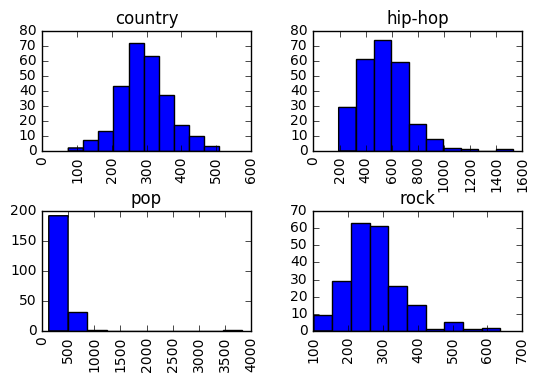

In [194]:
final_df.hist(column='token_count', by='Genre');

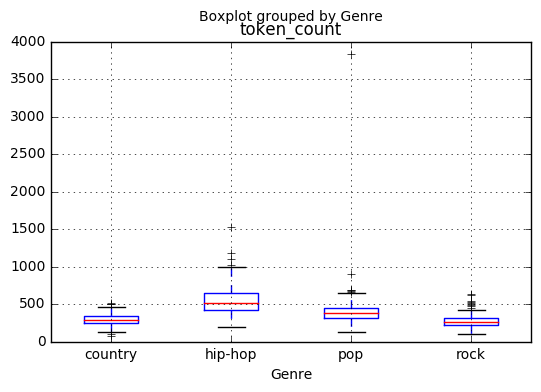

In [195]:
final_df.boxplot(column='token_count', by='Genre');

As we can see from above this data happens to have a very big outlier in the pop genre that makes this dataset hard to visualize. We'll just filter out this data point

In [164]:
final_df2 = final_df[final_df.token_count < 2000]

For curiosity's sake too, we'll look at what song this happens to be.

In [251]:
final_df[final_df.token_count > 2000]#.iloc[0,2]

,Artist,Genre,Lyrics,Song,Years,token_count,Lyrics_Lancast_Stem,Lyrics_Porter_Stem
345,Pitbull,pop,"Pitbull\nYou don't get them girls loose, loose...",Don't Stop The Party,2013,3833,"pitbul you don't get them girl loose, loos (tj...","Pitbul You don't get them girl loose, loos (TJ..."


Don't stop the party by Pitbull.

This song is 3 minues 33 seconds long on youtube and it has a alleged word count of 3833 words. That would be about 18 words a second, so I think it's safe to assume that the lyrics for the song aren't correct.

After filtering out that song our boxplot looks much better, and as we might expect there is a clear difference between the genres when it comes to token count.

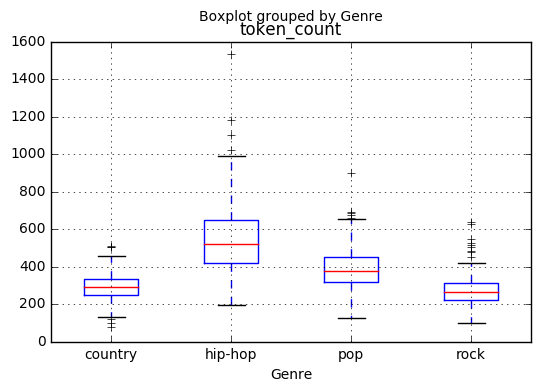

In [196]:
final_df2.boxplot(column='token_count', by='Genre');

<a id="5.3.2"></a>
### 5.3.2 Percentage of Unique Words

We can also expect some genres to be more likely to repeat words, so this metric could be helpful to us.

In [177]:
final_df2['num_unique_words'] = final_df2['Lyrics'].apply(lambda x: len(set(x.split())))

In [180]:
final_df2['percent_unique_words'] = final_df2['num_unique_words']/final_df2['token_count']

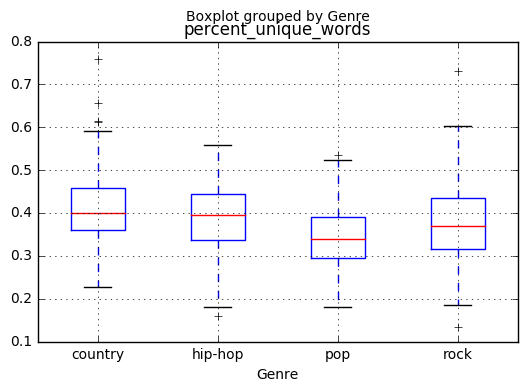

In [197]:
final_df2.boxplot(column='percent_unique_words', by='Genre');

This boxplot isn't as distinct as the earlier one, but we'll try it in our model anyways because we'll give the option to our GridSearchCV whether to use it or not.

<a id="5.4"></a>
## 5.4 Model Optimization

Despite our best efforts above it is still not abundantly clear what is the best model for our data. To determine this once and for all we are going to combine all of the different options into one massive parameter grid that we can scan over and compare.

<a id="5.4.1"></a>
### 5.4.1 Custom Transformers

To add our custom features to this final parameter search we are going to have to create our own custon transformers that'll work nicely with our data. Below we have two such transformers.

__ColSelector:__

  * __Description:__ This transformer is used for grabbing the specific column of data we're going to apply our transformers to.   
  
  * __Parameters:__
  
    * __key__ String given to ColSelector when initializing it. Represents the column you want out of DataFrame. Used in transform method to return the column with that key

__HotEncoder:__

  * __Description:__ This transformer is used for turning a numerical variable into bins and then turning these bins into the proper format for sklearn to use.
  
  * __Parameters:__ 
    * __bins:__ integer value for number of bins you want column seperated into.
    * __use_hot__: Boolean value that gives the option of ordinal encoding (0,1,... n where n =#bins) when False, and One-hot encoding when True 

In [252]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import FeatureUnion
import numpy as np
class ColSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]
    
class HotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, bins=5, use_hot=True):
        self.bins = bins
        self.use_hot = use_hot
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, col):
        
        if self.bins == None:
            return None
        if self.use_hot == False:
            return np.asmatrix(pd.qcut(col, self.bins, labels=[i for i in range(self.bins)])).T
        else:
            return np.asmatrix(pd.get_dummies(pd.qcut(col, self.bins)))

<a id="5.4.2"></a>
### 5.4.2 Creating our Pipeline

The transformers we created above are merged together with the help of FeatureUnion in the Pipeline below. From this Pipeline you can see that we're still using MultinomialNB as our classifier, but if you wanted to try something else you could replace it here.

It is also worth noting that with the TfidfTransformer in our Pipeline below when its parameters norm=None and use_idf=False nothing happens to our dataset so this is the same as if CountVectorizer was alone. This allows us to easily switch between TF-IDF and Bag of Words inside of a Pipeline.

In [306]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[ 
                    ('text', Pipeline([
                        ('selector', ColSelector(key='Lyrics')),
                        ('cv', CountVectorizer(ngram_range=(1,1), stop_words='english')),
                        ('tfidf', TfidfTransformer(norm=None, use_idf=False)),
                    ])),
                    ('hot_encoding_cnt', Pipeline([
                        ('selector', ColSelector(key='token_count')),
                        ('encoder', HotEncoder())
                    ])),
                    ('hot_encoding_perc', Pipeline([
                        ('selector', ColSelector(key='percent_unique_words')),
                        ('encoder', HotEncoder())
                    ])),

                    ])
     ),
    ('multinomialnb', MultinomialNB()),
    ])

<a id="5.4.3"></a>
### 5.4.3 Finding Optimal Parameters with RandomizedSearchCV

Since we are going to be searching over so many different parameters GridSearchCV would take way too long to run in entirety. We will instead opt to use RandomizedSearchCV which instead will pick random sets of parameters to test. RandomizedSearchCV will only run for as many iterations as you give it making it better to use when short on time.

We also commented out many of the parameters in our params list but if you want to use them in the model you can easily uncomment them. When these lines are uncommented the RandomizedSearchCV is trying many things like TF-IDF, stemming, and bi-grams which we decided to leave out of our final model because we realized they didn't make much of a difference earlier and they increase our parameters we're searching over in a combinatorial way.

In [307]:
from sklearn.grid_search import RandomizedSearchCV
from time import time

In [349]:
n_iter = 800
random_state = 0
test_size = .1

#Start timing
t0 = time()

X_train, X_test, y_train, y_test = train_test_split(final_df2, final_df2['Genre'],
                                                    test_size=test_size)#, random_state=random_state)

params = {
    'union__text__cv__ngram_range':[(1,1), (1,2)],
    'union__text__cv__min_df':[2, 4, 6, 8, 10, 15, 20, 25],
    'union__text__cv__max_df':[.5, .75, 1.0],
    'union__text__cv__stop_words':[None, 'english'],
    #'union__text__selector__key':['Lyrics', 'Lyrics_Lancast_Stem', 'Lyrics_Porter_Stem'],
    #'union__text__tfidf__norm':[None, 'l1', 'l2'],
    #'union__text__tfidf__use_idf':[True, False],
    'union__hot_encoding_cnt__encoder__bins':[None, 3, 4, 5, 6],
    'union__hot_encoding_perc__encoder__bins':[None, 3, 4, 5, 6],
    'union__hot_encoding_cnt__encoder__use_hot':[True, False],
    'union__hot_encoding_perc__encoder__use_hot':[True, False],
    'multinomialnb__alpha':[.1, .25, .5, 1.0]
}

grid = RandomizedSearchCV(pipeline, params, cv=5, n_iter=n_iter)
grid.fit(X_train, y_train)
print("Best CV Score: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Score for test sample held out: {}".format(accuracy_score(y_test, grid.predict(X_test))))
print("The RandomizedSearchCV ran {} iterations and it took {} seconds".format(n_iter, time()-t0))

Best CV Score: 0.71
Best parameters: {'union__hot_encoding_perc__encoder__bins': 5, 'union__text__cv__max_df': 0.75, 'union__hot_encoding_perc__encoder__use_hot': False, 'union__text__cv__min_df': 15, 'union__text__cv__ngram_range': (1, 1), 'union__text__cv__stop_words': None, 'union__hot_encoding_cnt__encoder__use_hot': True, 'union__hot_encoding_cnt__encoder__bins': 5, 'multinomialnb__alpha': 0.5}
Score for test sample held out: 0.71875
The RandomizedSearchCV ran 800 iterations and it took 2253.623588323593 seconds


From running 800 iterations we can see that our model's best CV score and test sample held out are both better than what we had before.

To test these parameters we will try them out on a random split, and see a classification report of the results.

In [355]:
X_train, X_test, y_train, y_test = train_test_split(final_df2, final_df2['Genre'])

pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[ 
                    ('text', Pipeline([
                        ('selector', ColSelector(key='Lyrics')),
                        ('cv', CountVectorizer(ngram_range=(1,1), min_df=15, max_df=.75, stop_words=None)),
                        ('tfidf', TfidfTransformer(norm=None, use_idf=False)),
                    ])),
                    ('hot_encoding_cnt', Pipeline([
                        ('selector', ColSelector(key='token_count')),
                        ('encoder', HotEncoder(bins=5, use_hot=True))
                    ])),
                    ('hot_encoding_perc', Pipeline([
                        ('selector', ColSelector(key='percent_unique_words')),
                        ('encoder', HotEncoder(bins=5, use_hot=False))
                    ])),

                      ])
     ),
    ('multinomialnb', MultinomialNB(alpha=.5)),
    ])

pipeline.fit(X_train, y_train)

print(classification_report(y_test, pipeline.predict(X_test)))

             precision    recall  f1-score   support

    country       0.78      0.79      0.79        77
    hip-hop       0.76      0.75      0.75        59
        pop       0.46      0.47      0.47        53
       rock       0.74      0.73      0.73        51

avg / total       0.70      0.70      0.70       240



These parameters do in fact give us a better model

In [356]:
# from sklearn.ensemble import RandomForestClassifier
# pipeline = Pipeline([
#     ('union', FeatureUnion(
#         transformer_list=[ 
#                     ('text', Pipeline([
#                         ('selector', ColSelector(key='Lyrics')),
#                         ('cv', CountVectorizer(ngram_range=(1,1), stop_words='english')),
#                         ('tfidf', TfidfTransformer(norm=None, use_idf=False)),
#                     ])),
#                     ('hot_encoding_cnt', Pipeline([
#                         ('selector', ColSelector(key='token_count')),
#                         ('encoder', HotEncoder())
#                     ])),
#                     ('hot_encoding_perc', Pipeline([
#                         ('selector', ColSelector(key='percent_unique_words')),
#                         ('encoder', HotEncoder())
#                     ])),

#                     ])
#      ),
#     ('randomforestclassifier', RandomForestClassifier()),
#     ])

In [358]:
# n_iter = 50
# random_state = 0
# test_size = .1

# #Start timing
# t0 = time()

# X_train, X_test, y_train, y_test = train_test_split(final_df2, final_df2['Genre'],
#                                                     test_size=test_size)#, random_state=random_state)

# params = {
#     'union__text__cv__ngram_range':[(1,1), (1,2)],
#     'union__text__cv__min_df':[2, 4, 6, 8, 10, 15, 20, 25],
#     'union__text__cv__max_df':[.5, .75, 1.0],
#     'union__text__cv__stop_words':[None, 'english'],
#     #'union__text__selector__key':['Lyrics', 'Lyrics_Lancast_Stem', 'Lyrics_Porter_Stem'],
#     #'union__text__tfidf__norm':[None, 'l1', 'l2'],
#     #'union__text__tfidf__use_idf':[True, False],
#     'union__hot_encoding_cnt__encoder__bins':[None, 3, 4, 5, 6],
#     'union__hot_encoding_perc__encoder__bins':[None, 3, 4, 5, 6],
#     'union__hot_encoding_cnt__encoder__use_hot':[True, False],
#     'union__hot_encoding_perc__encoder__use_hot':[True, False],
#     'randomforestclassifier__n_estimators':[150, 200, 500, 600, 800]
    
# }

# grid = RandomizedSearchCV(pipeline, params, cv=5, n_iter=n_iter)
# grid.fit(X_train, y_train)
# print("Best CV Score: {:.2f}".format(grid.best_score_))
# print("Best parameters: {}".format(grid.best_params_))
# print("Score for test sample held out: {}".format(accuracy_score(y_test, grid.predict(X_test))))
# print("The RandomizedSearchCV ran {} iterations and it took {} seconds".format(n_iter, time()-t0))

Best CV Score: 0.72
Best parameters: {'randomforestclassifier__n_estimators': 500, 'union__hot_encoding_perc__encoder__bins': 4, 'union__text__cv__max_df': 0.5, 'union__hot_encoding_perc__encoder__use_hot': True, 'union__text__cv__min_df': 6, 'union__text__cv__ngram_range': (1, 1), 'union__text__cv__stop_words': None, 'union__hot_encoding_cnt__encoder__use_hot': False, 'union__hot_encoding_cnt__encoder__bins': 6}
Score for test sample held out: 0.6041666666666666
The RandomizedSearchCV ran 50 iterations and it took 1233.376531124115 seconds


<a id='6' ></a>
# 6 Conclusion

Through machine learning we are able to predict what genre a song will be solely based upon the lyrics, with a pretty accurate margin. Through this notebook we noticed some interesting things like different genres will use different tenses of a word. This made stemming perform worse than not stemming in many cases.